Ref: https://levelup.gitconnected.com/building-seq2seq-lstm-with-luong-attention-in-keras-for-time-series-forecasting-1ee00958decb

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Import data

In [58]:
data = pd.read_csv('../data/num_file/min_10/p040.csv')

In [59]:
print(data)

                  datetime  count
0      2022-04-21 01:40:00    200
1      2022-04-21 01:50:00    833
2      2022-04-21 02:00:00     65
3      2022-04-21 02:10:00      0
4      2022-04-21 02:20:00      0
...                    ...    ...
19495  2022-09-03 10:50:00   4034
19496  2022-09-03 11:00:00   3556
19497  2022-09-03 11:10:00   1082
19498  2022-09-03 11:20:00   3937
19499  2022-09-03 11:30:00   4176

[19500 rows x 2 columns]


If there is no people, use NaN.

In [60]:
data.loc[data['count']==0, 'count'] = np.NaN

In [61]:
print(data)

                  datetime   count
0      2022-04-21 01:40:00   200.0
1      2022-04-21 01:50:00   833.0
2      2022-04-21 02:00:00    65.0
3      2022-04-21 02:10:00     NaN
4      2022-04-21 02:20:00     NaN
...                    ...     ...
19495  2022-09-03 10:50:00  4034.0
19496  2022-09-03 11:00:00  3556.0
19497  2022-09-03 11:10:00  1082.0
19498  2022-09-03 11:20:00  3937.0
19499  2022-09-03 11:30:00  4176.0

[19500 rows x 2 columns]


<Axes: >

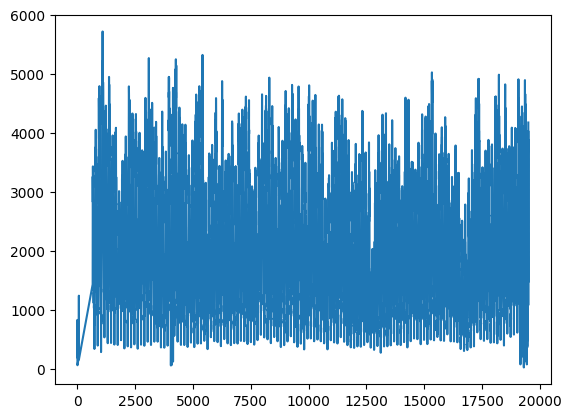

In [62]:
data['count'] = data['count'].interpolate(method='linear')
data['count'].plot()

## Normalize data

<Axes: >

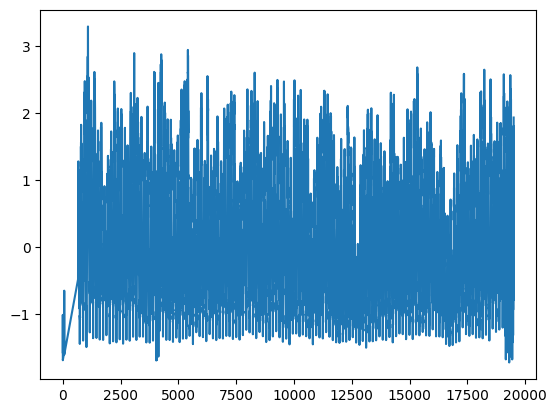

In [63]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data['count'] = scaler.fit_transform(data[['count']])
data['count'].plot()

In [64]:
print(data)

                  datetime     count
0      2022-04-21 01:40:00 -1.563824
1      2022-04-21 01:50:00 -1.007215
2      2022-04-21 02:00:00 -1.682532
3      2022-04-21 02:10:00 -1.680572
4      2022-04-21 02:20:00 -1.678611
...                    ...       ...
19495  2022-09-03 10:50:00  1.807486
19496  2022-09-03 11:00:00  1.387171
19497  2022-09-03 11:10:00 -0.788265
19498  2022-09-03 11:20:00  1.722192
19499  2022-09-03 11:30:00  1.932349

[19500 rows x 2 columns]


In [65]:
encode_input_data = []
decode_input_data = []
decode_output_data = []
time_step = 6

for i in range(len(data)-time_step-1):
    encode_input_data.append(data['count'].values[i:i+time_step])
    decode_input_data.append(data['count'].values[i:i+time_step])
    decode_output_data.append(data['count'].values[i+1:i+time_step+1])

encode_input_data = np.array(encode_input_data)
decode_input_data = np.array(decode_input_data)
decode_output_data = np.array(decode_output_data)

In [66]:
encode_input_data = encode_input_data.reshape(encode_input_data.shape[0], encode_input_data.shape[1], 1)
decode_input_data = decode_input_data.reshape(decode_input_data.shape[0], decode_input_data.shape[1], 1)
decode_output_data = decode_output_data.reshape(decode_output_data.shape[0], decode_output_data.shape[1], 1)

In [67]:
train_size = int(len(encode_input_data)*0.8)
encode_input_data_train = encode_input_data[:train_size]
decode_input_data_train = decode_input_data[:train_size]
decode_output_data_train = decode_output_data[:train_size]
encode_input_data_test = encode_input_data[train_size:]
decode_input_data_test = decode_input_data[train_size:]
decode_output_data_test = decode_output_data[train_size:]

## Model

In [68]:
from keras.layers import Input, LSTM, BatchNormalization, RepeatVector, TimeDistributed, Dense, dot, multiply, concatenate, Activation, GRU
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [69]:
input_train = Input(shape=(time_step, 1))
output_train = Input(shape=(time_step, 1))

In [70]:
'''
lstm_1 = LSTM(32, return_sequences=True, return_state=False)(input_train)
norm_lstm_1 = BatchNormalization()(lstm_1)
'''

'\nlstm_1 = LSTM(32, return_sequences=True, return_state=False)(input_train)\nnorm_lstm_1 = BatchNormalization()(lstm_1)\n'

In [71]:
# encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(32, activation='relu', return_sequences=False, return_state=True)(input_train)
encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(32, return_sequences=False, return_state=True)(input_train)

In [72]:
encoder_last_h1 = BatchNormalization()(encoder_last_h1)
encoder_last_c = BatchNormalization()(encoder_last_c)

In [73]:
decoder = RepeatVector(time_step)(encoder_last_h1)
# decoder = LSTM(32, activation='relu', return_state=False, return_sequences=True)(decoder, initial_state=[encoder_last_h1, encoder_last_c])
decoder = LSTM(32, return_state=False, return_sequences=True)(decoder, initial_state=[encoder_last_h1, encoder_last_c])

In [74]:
# lstm_decode = LSTM(32, return_sequences=True, return_state=False)(decoder)

In [75]:
out = TimeDistributed(Dense(1))(decoder)

In [76]:
model = Model(inputs=input_train, outputs=out)
opt = Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 6, 1)]       0           []                               
                                                                                                  
 lstm_4 (LSTM)                  [(None, 32),         4352        ['input_5[0][0]']                
                                 (None, 32),                                                      
                                 (None, 32)]                                                      
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 32)          128         ['lstm_4[0][0]']                 
 rmalization)                                                                               

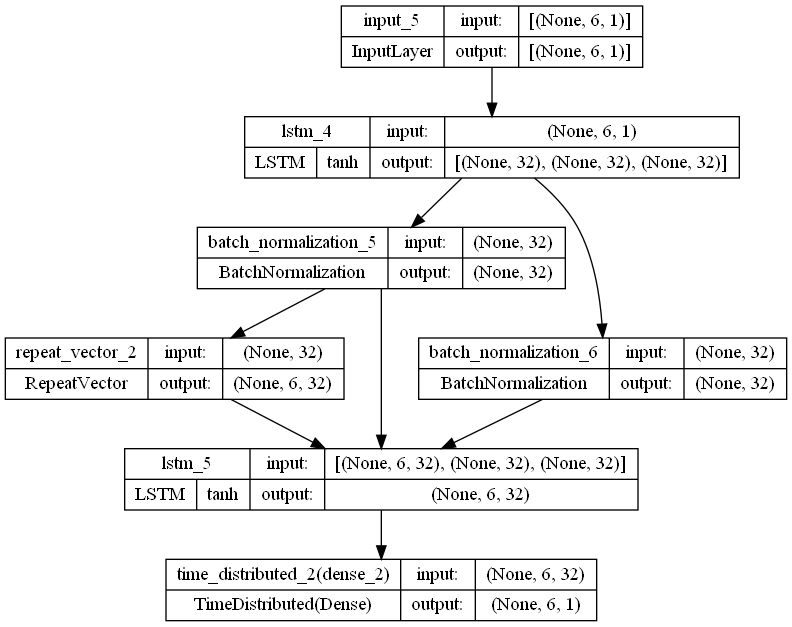

In [77]:
from keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_activations=True)

In [78]:
es = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
history = model.fit(encode_input_data_train, decode_output_data_train, epochs=100, batch_size=128, validation_split=0.1, callbacks=[es], shuffle=True)

Epoch 1/100
110/110 [==============================] - 3s 9ms/step - loss: 0.0475 - mae: 0.1512 - val_loss: 0.3212 - val_mae: 0.4949
Epoch 2/100
110/110 [==============================] - 1s 5ms/step - loss: 0.0263 - mae: 0.1184 - val_loss: 0.1575 - val_mae: 0.3367
Epoch 3/100
110/110 [==============================] - 1s 5ms/step - loss: 0.0232 - mae: 0.1103 - val_loss: 0.0655 - val_mae: 0.1970
Epoch 4/100
110/110 [==============================] - 1s 5ms/step - loss: 0.0232 - mae: 0.1127 - val_loss: 0.0241 - val_mae: 0.1130
Epoch 5/100
110/110 [==============================] - 1s 5ms/step - loss: 0.0190 - mae: 0.0986 - val_loss: 0.0233 - val_mae: 0.1205
Epoch 6/100
110/110 [==============================] - 1s 5ms/step - loss: 0.0180 - mae: 0.0967 - val_loss: 0.0183 - val_mae: 0.1049
Epoch 7/100
110/110 [==============================] - 1s 5ms/step - loss: 0.0166 - mae: 0.0910 - val_loss: 0.0172 - val_mae: 0.0918
Epoch 8/100
110/110 [==============================] - 1s 5ms/step - 

In [79]:
# model.save('./params/p040_seq2seq.keras')

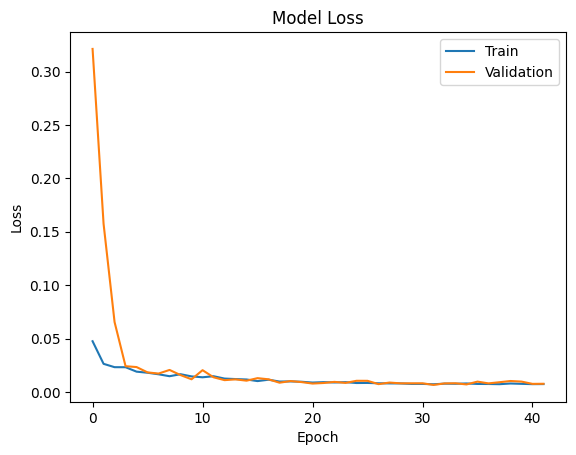

In [80]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


In [81]:
predict_train = model.predict(encode_input_data_train)

488/488 [==============================] - 1s 2ms/step


In [82]:
predict_test = model.predict(encode_input_data_test)

122/122 [==============================] - 0s 2ms/step


In [83]:
print(predict_train.shape)

(15594, 6, 1)


In [84]:
print(predict_test.shape)

(3899, 6, 1)


In [85]:
predict = np.concatenate([predict_train, predict_test], axis=0)
print(predict.shape)

(19493, 6, 1)


In [86]:
print(predict_test[:, -1, :])

[[-0.41989344]
 [-0.28277284]
 [-0.46550268]
 ...
 [ 1.5429704 ]
 [ 1.46393   ]
 [ 0.2892409 ]]


In [87]:
print(decode_output_data_test[:, -1, :])

[[-0.38729511]
 [-0.41631265]
 [-0.55436576]
 ...
 [ 1.38717097]
 [-0.78826465]
 [ 1.72219157]]


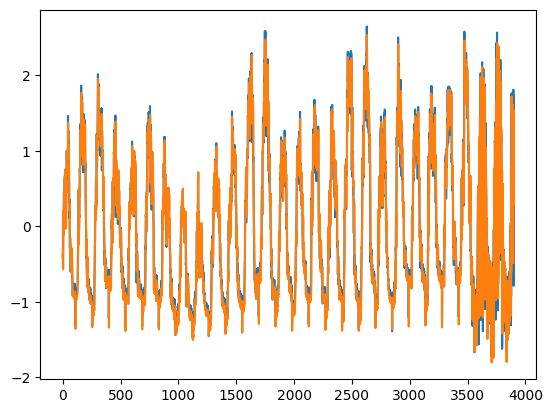

In [88]:
plt.plot(np.arange(decode_output_data_test.shape[0]), decode_output_data_test[:, -1, :])
plt.plot(np.arange(predict_test.shape[0]), predict_test[:, -1, :])
plt.show()

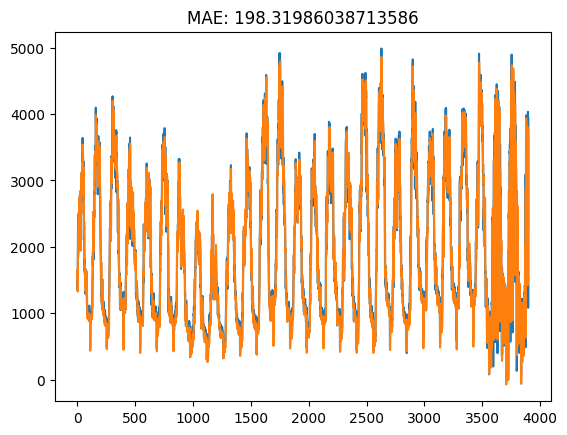

In [89]:
predict_test_data = scaler.inverse_transform(predict_test[:, -1, :])
decode_output_test_data = scaler.inverse_transform(decode_output_data_test[:, -1, :])
plt.plot(np.arange(decode_output_test_data.shape[0]), decode_output_test_data)
plt.plot(np.arange(predict_test_data.shape[0]), predict_test_data)
plt.title(f'MAE: {np.mean(np.abs((predict_test_data-decode_output_test_data)))}')
plt.show()

## Attention

In [90]:
input_train = Input(shape=(time_step, 1))
output_train = Input(shape=(time_step, 1))

In [91]:
# encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(32, activation='relu', return_sequences=True, return_state=True)(input_train)
encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(32, return_sequences=True, return_state=True)(input_train)
print(encoder_stack_h)
print(encoder_last_h)
print(encoder_last_c)

KerasTensor(type_spec=TensorSpec(shape=(None, 6, 32), dtype=tf.float32, name=None), name='lstm_6/PartitionedCall:1', description="created by layer 'lstm_6'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='lstm_6/PartitionedCall:2', description="created by layer 'lstm_6'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='lstm_6/PartitionedCall:3', description="created by layer 'lstm_6'")


In [92]:
encoder_last_h = BatchNormalization()(encoder_last_h)
encoder_last_c = BatchNormalization()(encoder_last_c)

In [93]:
decoder_input = RepeatVector(time_step)(encoder_last_h)
print(decoder_input)

KerasTensor(type_spec=TensorSpec(shape=(None, 6, 32), dtype=tf.float32, name=None), name='repeat_vector_3/Tile:0', description="created by layer 'repeat_vector_3'")


In [94]:
# decoder_stack_h = LSTM(32, activation='relu', return_sequences=True)(decoder_input, initial_state=[encoder_last_h, encoder_last_c])
decoder_stack_h = LSTM(32, return_sequences=True)(decoder_input, initial_state=[encoder_last_h, encoder_last_c])
print(decoder_stack_h)

KerasTensor(type_spec=TensorSpec(shape=(None, 6, 32), dtype=tf.float32, name=None), name='lstm_7/PartitionedCall:1', description="created by layer 'lstm_7'")


In [95]:
attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])

In [96]:
attention = Activation('relu')(attention)

In [97]:
print(attention)

KerasTensor(type_spec=TensorSpec(shape=(None, 6, 6), dtype=tf.float32, name=None), name='activation_1/Relu:0', description="created by layer 'activation_1'")


In [98]:
context = dot([attention, encoder_stack_h], axes=[2, 1])
context = BatchNormalization()(context)
print(context)

KerasTensor(type_spec=TensorSpec(shape=(None, 6, 32), dtype=tf.float32, name=None), name='batch_normalization_9/batchnorm/add_1:0', description="created by layer 'batch_normalization_9'")


In [99]:
decoder_combined_context = concatenate([context, decoder_stack_h])
print(decoder_combined_context)

KerasTensor(type_spec=TensorSpec(shape=(None, 6, 64), dtype=tf.float32, name=None), name='concatenate_1/concat:0', description="created by layer 'concatenate_1'")


In [100]:
out = TimeDistributed(Dense(1))(decoder_combined_context)
print(out)

KerasTensor(type_spec=TensorSpec(shape=(None, 6, 1), dtype=tf.float32, name=None), name='time_distributed_3/Reshape_1:0', description="created by layer 'time_distributed_3'")


In [101]:
model = Model(inputs=input_train, outputs=out)
opt = Adam(learning_rate=0.01, clipnorm=1.0)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 6, 1)]       0           []                               
                                                                                                  
 lstm_6 (LSTM)                  [(None, 6, 32),      4352        ['input_7[0][0]']                
                                 (None, 32),                                                      
                                 (None, 32)]                                                      
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 32)          128         ['lstm_6[0][1]']                 
 rmalization)                                                                               

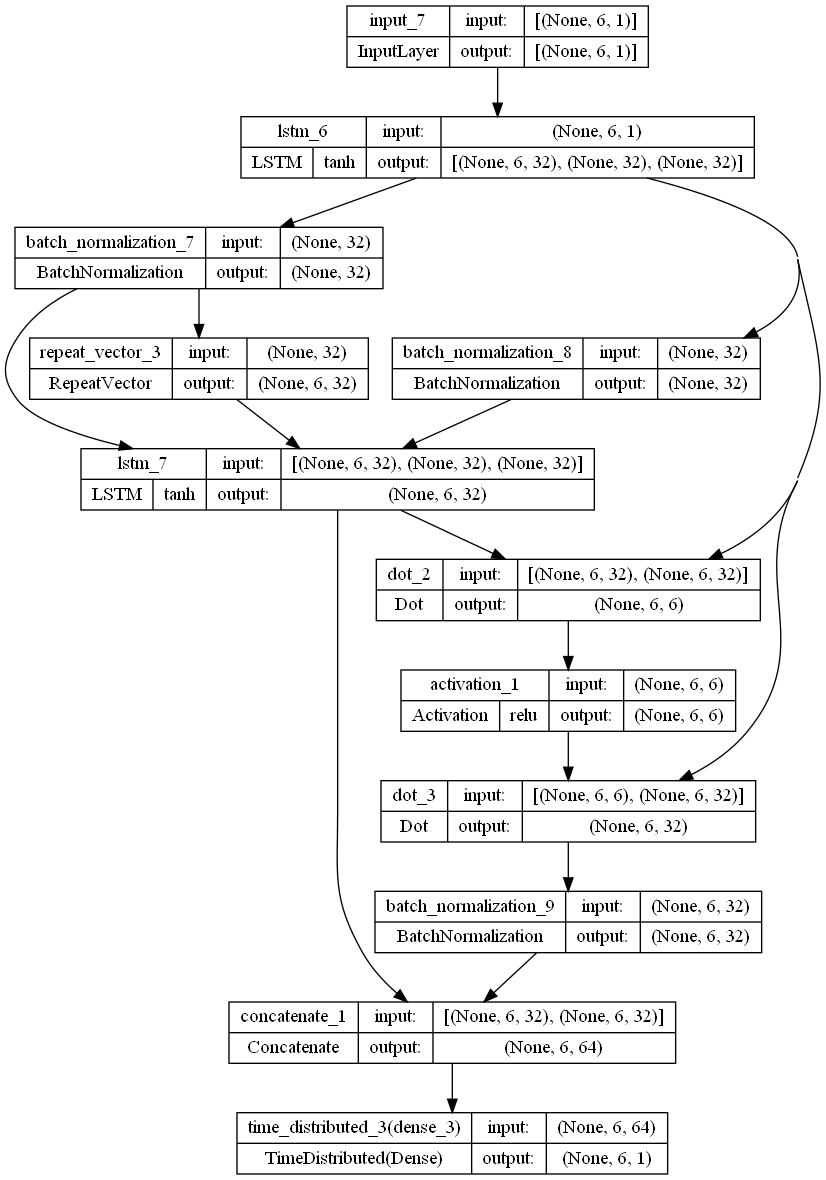

In [102]:
from keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_activations=True)

In [103]:
history = model.fit(encode_input_data_train, decode_output_data_train, epochs=100, batch_size=128, validation_split=0.1, callbacks=[es], shuffle=True)

Epoch 1/100
110/110 [==============================] - 3s 11ms/step - loss: 0.0562 - mae: 0.1615 - val_loss: 0.4909 - val_mae: 0.6222
Epoch 2/100
110/110 [==============================] - 1s 7ms/step - loss: 0.0405 - mae: 0.1509 - val_loss: 0.1370 - val_mae: 0.3239
Epoch 3/100
110/110 [==============================] - 1s 7ms/step - loss: 0.0322 - mae: 0.1317 - val_loss: 0.0544 - val_mae: 0.1967
Epoch 4/100
110/110 [==============================] - 1s 7ms/step - loss: 0.0272 - mae: 0.1201 - val_loss: 0.0258 - val_mae: 0.1146
Epoch 5/100
110/110 [==============================] - 1s 7ms/step - loss: 0.0280 - mae: 0.1218 - val_loss: 0.0306 - val_mae: 0.1286
Epoch 6/100
110/110 [==============================] - 1s 8ms/step - loss: 0.0244 - mae: 0.1124 - val_loss: 0.0219 - val_mae: 0.1096
Epoch 7/100
110/110 [==============================] - 1s 7ms/step - loss: 0.0244 - mae: 0.1117 - val_loss: 0.0231 - val_mae: 0.1191
Epoch 8/100
110/110 [==============================] - 1s 7ms/step -

In [104]:
# model.save('./params/p040_seq2seq_at.keras')

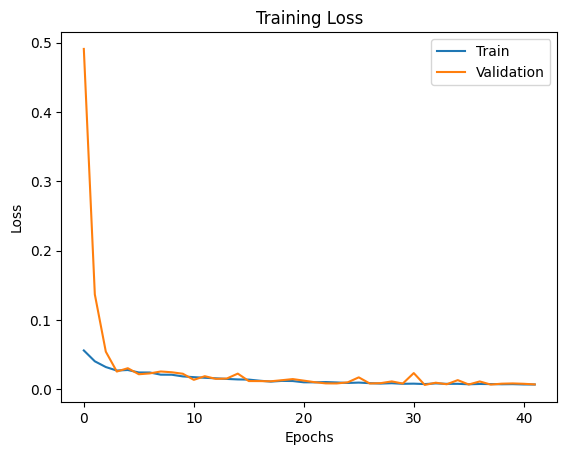

In [105]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()


In [106]:
predict_test = model.predict(encode_input_data_test)

122/122 [==============================] - 1s 2ms/step


In [107]:
predict_test_data = scaler.inverse_transform(predict_test[:, -1, :])

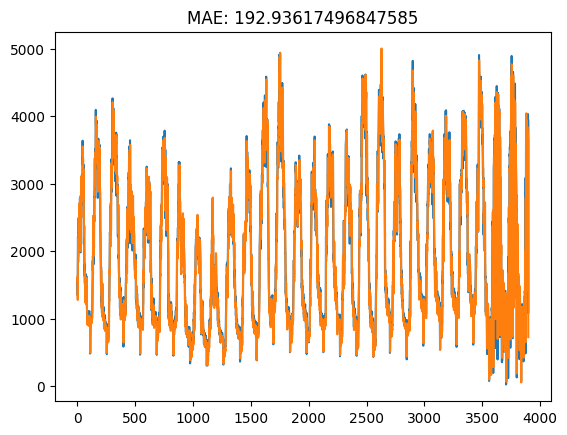

In [108]:
plt.plot(np.arange(decode_output_test_data.shape[0]), decode_output_test_data)
plt.plot(np.arange(predict_test_data.shape[0]), predict_test_data)
plt.title(f'MAE: {np.mean(np.abs((predict_test_data-decode_output_test_data)))}')
plt.show()

In [109]:
print(predict_test_data)

[[1562.1038 ]
 [1621.3534 ]
 [1392.8583 ]
 ...
 [3673.6814 ]
 [3624.5444 ]
 [ 727.51953]]


In [110]:
print(decode_output_test_data)

[[1538.]
 [1505.]
 [1348.]
 ...
 [3556.]
 [1082.]
 [3937.]]


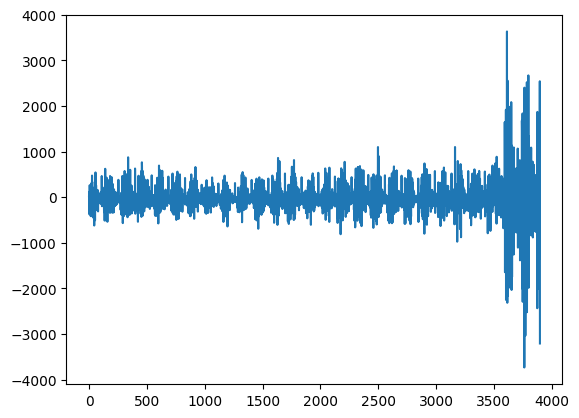

In [111]:
plt.plot(np.arange(decode_output_test_data.shape[0]), predict_test_data-decode_output_test_data)

In [112]:
from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(decode_output_test_data, predict_test_data))

192.93617496847585
